In [1]:
!pip install transformers datasets --quiet
!pip install umap-learn --quiet
!pip install -U torch==1.7.1 torchvision --quiet
!pip install ftfy regex tqdm --quiet
!pip install git+https://github.com/openai/CLIP.git --quiet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 8.3 MB/s 
     |████████████████████████████████| 212 kB 68.3 MB/s 
     |████████████████████████████████| 140 kB 70.8 MB/s 
     |████████████████████████████████| 86 kB 8.2 MB/s 
     |████████████████████████████████| 1.1 MB 61.4 MB/s 
     |████████████████████████████████| 84 kB 4.0 MB/s 
     |████████████████████████████████| 127 kB 71.5 MB/s 
     |████████████████████████████████| 271 kB 55.4 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
     |████████████████████████████████| 144 kB 71.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.5.1
    Uninstalling dill-0.3.5.1:
      Successfully uninstalled dill-0.3.5.1
ERROR: pip's depend

In [ ]:
!wget https://www.cl.uni-heidelberg.de/statnlpgroup/wikicaps/wikicaps_v1.0.tar.gz -O /content/parallel_captions.tar.gz
!tar -xf parallel_captions.tar.gz

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os, random
import torch

import warnings
warnings.filterwarnings("ignore")

import clip

In [4]:
!git clone https://github.com/FreddeFrallan/Multilingual-CLIP
!mv /content/Multilingual-CLIP /content/MultilingualCLIP
%cd MultilingualCLIP
!bash get-weights.sh

/content/MultilingualCLIP
--2022-05-24 16:36:32--  https://www.dropbox.com/s/s77xw5308jeljlp/Swedish-500k%20Linear%20Weights.pkl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/s77xw5308jeljlp/Swedish-500k%20Linear%20Weights.pkl [following]
--2022-05-24 16:36:33--  https://www.dropbox.com/s/raw/s77xw5308jeljlp/Swedish-500k%20Linear%20Weights.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbf5d7acab3a6b3671bb8b62807.dl.dropboxusercontent.com/cd/0/inline/Bl64vA9FcM8H9l10iOOh87VFELTpNni_Vke-ZJyQpgg1K5-4DZqAo96gMtDV1-7MOHgRWmPlGgCehTEXwbd7YH-QYKAHnJ7llBaoKzLU54eeMxe1vEs-sbxukfgtj5epwxoE-iadUeAHeof6Dzqg_rahsHbPfhRVHwYjlvUOrmcR5g/file# [following]
--2022-05-24 16:36:33--  https://ucbf5d7acab3a6b3671bb8b62807.dl.dropb

In [6]:
from MultilingualCLIP.src import multilingual_clip
text_model = multilingual_clip.load_model('M-BERT-Distil-40')

In [7]:
clip_model, compose = clip.load('RN50x4')

#input_resolution = clip_model.input_resolution.item()
context_length = clip_model.context_length
vocab_size = clip_model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
#print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 178,300,601
Context length: 77
Vocab size: 49408


In [8]:
%cd ..

/content


In [9]:
import os 

dev_files = [file_ for file_ in os.listdir('wikicaps_v1.0') if file_[-3:]=='dev']
test_files = [file_ for file_ in os.listdir('wikicaps_v1.0') if file_[-4:]=='test']
bilingvs = [item[4:9] for item in test_files]

In [10]:
bilingvs

['fr-en', 'de-en', 'ru-en']

In [11]:
import csv


dataset = dict()
for pair in bilingvs:
    cur_file = f'/content/wikicaps_v1.0/img_{pair}.tok.lc.filtered.dev'
    data_first = []
    data_second = []
    with open(cur_file) as tsv: 
        for line in csv.reader(tsv, delimiter='\t'):
            _, content = line
            first, second = content.split('|||')
            data_first.append(first)
            data_second.append(second)
    dataset[pair] = [data_first, data_second]

In [12]:
langauge_pairs = [['French', 'English'], ['Deutsch', 'English'], ['Russian', 'English']]

In [16]:
len(dataset['fr-en'][0])

999

In [17]:
batch_size = 100
embeddings = dict()
for pair in bilingvs: 
    data_first, data_second = dataset[pair]
    with torch.no_grad():
        cur_embs_first = []
        cur_embs_second = []
        for idx in range(0, len(data_first), batch_size):
            batch_first = text_model(data_first[idx:idx+batch_size])
            batch_second = text_model(data_second[idx:idx+batch_size])
            cur_embs_first.append(batch_first)
            cur_embs_second.append(batch_second)
    embeddings[pair] = [torch.cat(cur_embs_first, dim=0), torch.cat(cur_embs_second, dim=0)]

In [19]:
embeddings['fr-en'][1].shape

torch.Size([999, 640])

In [36]:
fr_en_np = {'french': embeddings['fr-en'][0].numpy(), 'english': embeddings['fr-en'][1].numpy()}
np.save('fr_en.npy', fr_en_np)
de_en_np = {'deutsch': embeddings['de-en'][0].numpy(), 'english': embeddings['de-en'][1].numpy()}
np.save('de_en.npy', de_en_np)
ru_en_np = {'russian': embeddings['ru-en'][0].numpy(), 'english': embeddings['ru-en'][1].numpy()}
np.save('ru_en.npy', ru_en_np)

In [29]:
import umap

reducer = umap.UMAP()

In [30]:
fr_en = torch.cat(embeddings['fr-en'], dim=0).numpy()
fr_en_reduced = reducer.fit_transform(fr_en)

In [32]:
de_en = torch.cat(embeddings['de-en'], dim=0).numpy()
de_en_reduced = reducer.fit_transform(de_en)

In [31]:
ru_en = torch.cat(embeddings['ru-en'], dim=0).numpy()
ru_en_reduced = reducer.fit_transform(ru_en)

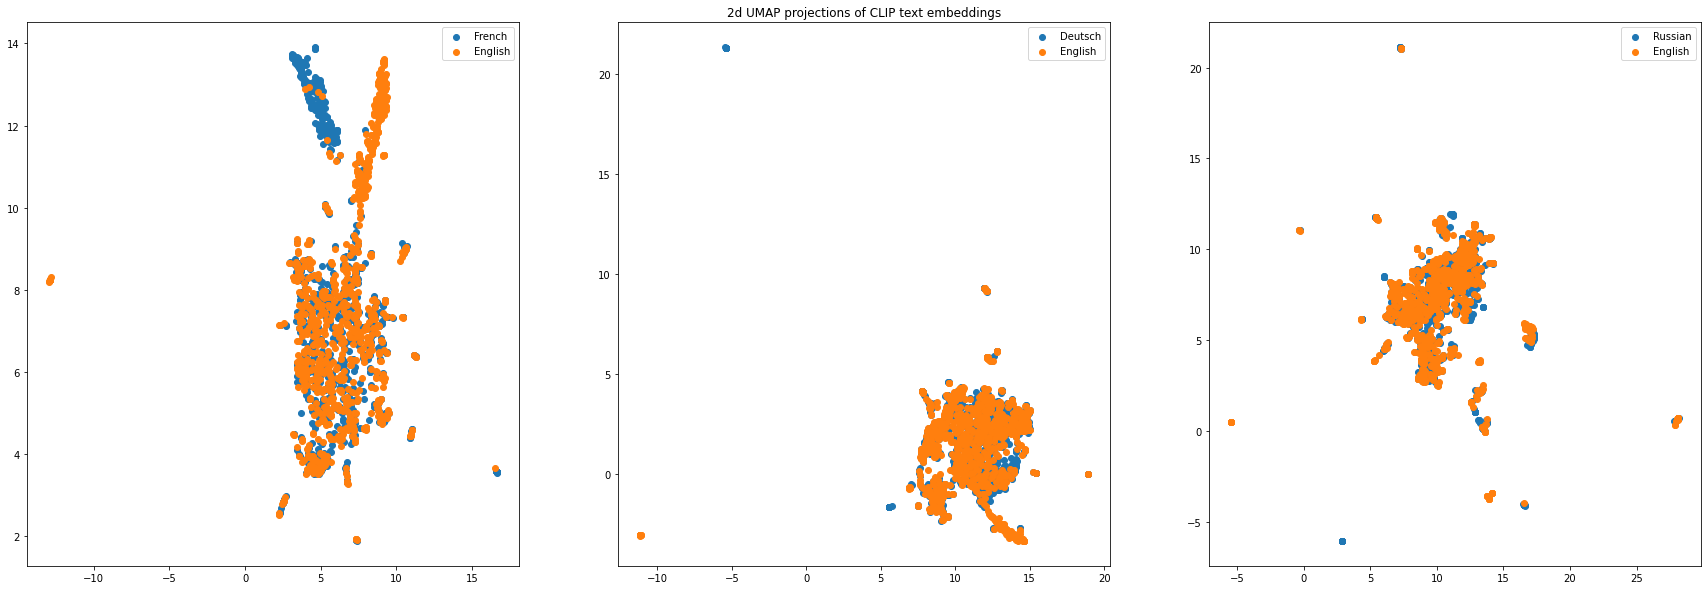

In [33]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(30, 10))
axs[0].scatter(fr_en_reduced[:999, 0], fr_en_reduced[:999, 1], label='French')
axs[0].scatter(fr_en_reduced[999:, 0], fr_en_reduced[999:, 1], label='English')
axs[0].legend()

axs[1].scatter(de_en_reduced[:999, 0], de_en_reduced[:999, 1], label='Deutsch')
axs[1].scatter(de_en_reduced[999:, 0], de_en_reduced[999:, 1], label='English')
axs[1].legend()

axs[2].scatter(ru_en_reduced[:999, 0], ru_en_reduced[:999, 1], label='Russian')
axs[2].scatter(ru_en_reduced[999:, 0], ru_en_reduced[999:, 1], label='English')
axs[2].legend()

axs[1].set_title('2d UMAP projections of CLIP text embeddings')
plt.show()

In [55]:
!gdown 1tgrRUqBvS33AGYfn_uVGrv-ekw0cjnVS
!gdown 1btSl7bYT3FMoAadaoxA0KmTHhqia6SWs
!gdown 1NvXTFbs8Di5wDoXmX9yEzesYrMYBqqJh

Downloading...
From: https://drive.google.com/uc?id=1tgrRUqBvS33AGYfn_uVGrv-ekw0cjnVS
To: /content/de_en.npy
100% 5.12M/5.12M [00:00<00:00, 112MB/s]
Downloading...
From: https://drive.google.com/uc?id=1btSl7bYT3FMoAadaoxA0KmTHhqia6SWs
To: /content/fr_en.npy
100% 5.12M/5.12M [00:00<00:00, 73.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NvXTFbs8Di5wDoXmX9yEzesYrMYBqqJh
To: /content/ru_en.npy
100% 5.12M/5.12M [00:00<00:00, 79.4MB/s]


In [3]:
de_en = np.load('de_en.npy', allow_pickle=True).item()
print(de_en.keys())
fr_en = np.load('fr_en.npy', allow_pickle=True).item()
print(fr_en.keys())
ru_en = np.load('ru_en.npy', allow_pickle=True).item()
print(ru_en.keys())

dict_keys(['deutsch', 'english'])
dict_keys(['french', 'english'])
dict_keys(['russian', 'english'])


In [25]:
def mean_pairwise_distance_to_mean_distance(cloud1, cloud2):
    mean_pairwise = ((cloud1 - cloud2) ** 2).sum(-1).mean()
    mean_dist = ((cloud1 - cloud2[:, None, :]) ** 2).sum(-1).mean()
    return {
        'mean pairwise distance': mean_pairwise,
        'sort of mean distance': mean_dist,
        'ratio': mean_pairwise / mean_dist
    }

In [26]:
mean_pairwise_distance_to_mean_distance(de_en['deutsch'], de_en['english'])

{'mean pairwise distance': 10.565027,
 'sort of mean distance': 37.85085,
 'ratio': 0.2791226}

In [27]:
mean_pairwise_distance_to_mean_distance(fr_en['french'], fr_en['english'])

{'mean pairwise distance': 10.192693,
 'sort of mean distance': 39.435593,
 'ratio': 0.2584643}

In [28]:
mean_pairwise_distance_to_mean_distance(ru_en['russian'], ru_en['english'])

{'mean pairwise distance': 14.444049,
 'sort of mean distance': 39.882046,
 'ratio': 0.3621692}

In [36]:
from sklearn.metrics.pairwise import pairwise_distances
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import ripserplusplus as rpp_py

def pdist_gpu(a, b, device = 'cuda:0'):
    A = torch.tensor(a, dtype = torch.float64)
    B = torch.tensor(b, dtype = torch.float64)

    size = (A.shape[0] + B.shape[0]) * A.shape[1] / 1e9
    max_size = 0.2

    if size > max_size:
        parts = int(size / max_size) + 1
    else:
        parts = 1

    pdist = np.zeros((A.shape[0], B.shape[0]))
    At = A.to(device)

    for p in range(parts):
        i1 = int(p * B.shape[0] / parts)
        i2 = int((p + 1) * B.shape[0] / parts)
        i2 = min(i2, B.shape[0])

        Bt = B[i1:i2].to(device)
        pt = torch.cdist(At, Bt)
        pdist[:, i1:i2] = pt.cpu()

        del Bt, pt
        torch.cuda.empty_cache()

    del At

    return pdist

def sep_dist(a, b, pdist_device = 'cpu'):
    if pdist_device == 'cpu':
        d1 = pairwise_distances(b, a, n_jobs = 40)
        d2 = pairwise_distances(b, b, n_jobs = 40)
    else:
        d1 = pdist_gpu(b, a, device = pdist_device)
        d2 = pdist_gpu(b, b, device = pdist_device)

    s = a.shape[0] + b.shape[0]

    apr_d = np.zeros((s, s))
    apr_d[a.shape[0]:, :a.shape[0]] = d1
    apr_d[a.shape[0]:, a.shape[0]:] = d2

    return apr_d

def barc2array(barc):
    keys = sorted(barc.keys())
    arr = []

    for k in keys:
        res = np.zeros((len(barc[k]), 2), dtype = '<f4')

        for idx in range(len(barc[k])):
            elem = barc[k][idx]
            res[idx, 0] = elem[0]
            res[idx, 1] = elem[1]

        arr.append(res)

    return np.array(arr, dtype=object)

def count_cross_barcodes(cloud_1, cloud_2, dim, title = '', is_plot = True, pdist_device = 'cpu'):

    d = sep_dist(cloud_1, cloud_2, pdist_device = pdist_device)
    m = d[cloud_1.shape[0]:, :cloud_1.shape[0]].mean()
    d[:cloud_1.shape[0]][:cloud_1.shape[0]] = 0
    d[d < m*(1e-6)] = 0
    d_tril = d[np.tril_indices(d.shape[0], k = -1)]

    barcodes = rpp_py.run("--format lower-distance --dim %d" % dim, d_tril)
    barcodes = barc2array(barcodes)

    if is_plot:
      plot_barcodes(barcodes, title = title)
      plt.show()

    return barcodes

def plot_barcodes(arr, color_list = ['deepskyblue', 'limegreen', 'darkkhaki'], dark_color_list = None, title = '', hom = None):

    if dark_color_list is None:
        dark_color_list = color_list
        #dark_color_list = ['b', 'g', 'orange']

    sh = arr.shape[0]
    step = 0
    if (len(color_list) < sh):
        color_list *= sh

    for i in range(sh):

        if not (hom is None):
            if i not in hom:
                continue

        barc = arr[i].copy()
        arrayForSort = np.subtract(barc[:,1],barc[:,0])

        bsorted = np.sort(arrayForSort)
        nbarc = bsorted.shape[0]
        print(nbarc)
        print('max0,976Barcode',i,'=',bsorted[nbarc*976//1000])
        print('maxBarcode',i,'=',bsorted[-1])
        print('middleBarcode',i,'=',bsorted[nbarc//2])
        #print('minbarcode',i,'=',bsorted[0])
        max = bsorted[-3:]
        plt.plot(barc[0], np.ones(2)*step, color = color_list[i], label = 'H{}'.format(i))
        for b in barc:
            if b[1] - b[0] in max :
                plt.plot(b, np.ones(2)*step, dark_color_list[i])
            else:
                plt.plot(b, np.ones(2)*step, color = color_list[i])
            step += 1

    plt.xlabel('$\epsilon$ (time)')
    plt.ylabel('segment')
    plt.title(title)
    plt.legend(loc = 'lower right')
    plt.rcParams["figure.figsize"] = [6, 4]

def calc_cross_barcodes(cloud_1, cloud_2, batch_size1 = 4000, batch_size2 = 200, pdist_device = 'cpu', dim = 1, is_plot = True):

    # NB !
    # Swapping point clouds for consistency with the paper
    cloud_1, cloud_2 = cloud_2, cloud_1
    batch_size1, batch_size2 = batch_size2, batch_size1

    batch_size1 = min(batch_size1, cloud_1.shape[0])
    batch_size2 = min(batch_size2, cloud_2.shape[0])

    indexes_1 = np.random.choice(cloud_1.shape[0], batch_size1, replace=False)
    indexes_2 = np.random.choice(cloud_2.shape[0], batch_size2, replace=False)
    cl_1 = cloud_1[indexes_1]
    cl_2 = cloud_2[indexes_2]
    barc = count_cross_barcodes(cl_1, cl_2, dim, is_plot = is_plot, title = '', pdist_device = pdist_device)

    return barc

def get_score(elem, h_idx, kind = ''):
    if elem.shape[0] >= h_idx + 1:

        barc = elem[h_idx]
        arrayForSort = np.subtract(barc[:,1], barc[:,0])

        bsorted = np.sort(arrayForSort)

        # number of barcodes
        if kind == 'nbarc':
            return bsorted.shape[0]

        # largest barcode
        if kind == 'largest':
            return bsorted[-1]

        # quantile
        if kind == 'quantile':
            idx = int(0.976 * len(bsorted))
            return bsorted[idx]

        # sum of length
        if kind == 'sum_length':
            return np.sum(bsorted)

        # sum of squared length
        if kind == 'sum_sq_length':
            return np.sum(bsorted**2)

        raise ValueError('Unknown kind of score')

    return 0

#
# P - first point cloud
# Q - second point cloud
# batch_size1 - number of points to sample from the first point cloud
# batch_size2 - number of points to sample from the second point cloud
# pdist_device - device to calculate pairwise distances 'cpu'/'cuda:N'
#
def mtopdiv(P, Q, batch_size1 = 1000, batch_size2 = 1000, n = 20, pdist_device = 'cuda:0', is_plot = False):
    barcs = [calc_cross_barcodes(P, Q, batch_size1, batch_size2, pdist_device = pdist_device, is_plot = is_plot) for _ in range(n)]
    return np.mean([get_score(x, 1, 'sum_length') for x in barcs])

In [37]:
mtopdiv(ru_en['russian'], ru_en['english'], pdist_device = 'cuda:0')

57.19353

In [38]:
mtopdiv(fr_en['english'], de_en['english'], pdist_device = 'cuda:0')

44.175945

In [39]:
mtopdiv(fr_en['french'], de_en['deutsch'], pdist_device = 'cuda:0')

42.553425

In [40]:
mtopdiv(ru_en['russian'], de_en['deutsch'], pdist_device = 'cuda:0')

42.000984